In [1]:
import numpy as np
import torch
from torch import nn
from tropical import to_tensor, Tropical, TropicalMonomial, TropicalPolynomial, PolyNet, DiffPolyNet, convert_net_to_tropical

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import JuPyMake
JuPyMake.InitializePolymake()
JuPyMake.ExecuteCommand("application 'tropical';")

(True, '', '', '')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
class Net(torch.nn.Module):
    def __init__(self, inp_size, out_size, bias=True):
        super(Net, self).__init__()
        
        self.linears = nn.ModuleList([nn.Linear(inp_size[0], out_size[0], bias=bias)])
        
        for i in range(1, len(inp_size)):
            self.linears.extend([nn.Linear(inp_size[i], out_size[i], bias=bias)])

    def forward(self, output):
        for i, l in enumerate(self.linears):
            output = l.forward(output)
            if i<len(self.linears)-1:
                output = torch.relu(output)
        return output

# Создадим стандартную классификационную задачу

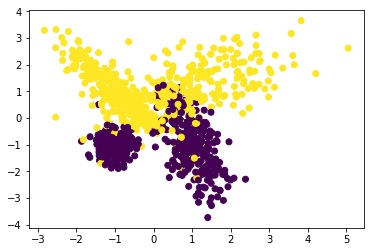

In [6]:
from sklearn.datasets import make_classification, make_moons, make_gaussian_quantiles

X, Y = make_classification(n_samples=1000,n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=2,
                           n_classes=2, random_state=5)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y)   
x_t = torch.from_numpy(X).float()
y_t = torch.from_numpy(Y).long()

In [7]:
#создаем двухслойную сеть
inp_size = [2,10]
out_size = [10,2]
model = Net(inp_size,out_size,bias=True)

epochs = 1000
batch_size = 100
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

dataset = torch.utils.data.TensorDataset(x_t, y_t)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)


for epoch in range(epochs):
    loss_epoch = 0
    for x, y in loader:
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        loss_epoch += loss.item()
        
        opt.step()
        opt.zero_grad()
    
    if epoch%100 == 0:
        with torch.no_grad():
            acc = (model.forward(x_t).argmax(1)==y_t.flatten()).float().mean()
        print('Epoch: ', epoch, ' loss: ', loss_epoch, 'acc: ', acc)

Epoch:  0  loss:  11.070485293865204 acc:  tensor(0.2590)
Epoch:  100  loss:  2.400958999991417 acc:  tensor(0.9160)
Epoch:  200  loss:  2.2034904956817627 acc:  tensor(0.9270)
Epoch:  300  loss:  2.061361327767372 acc:  tensor(0.9310)
Epoch:  400  loss:  1.9592166244983673 acc:  tensor(0.9320)
Epoch:  500  loss:  1.8880217224359512 acc:  tensor(0.9310)
Epoch:  600  loss:  1.8368839770555496 acc:  tensor(0.9290)
Epoch:  700  loss:  1.8043977469205856 acc:  tensor(0.9300)
Epoch:  800  loss:  1.7826875895261765 acc:  tensor(0.9310)
Epoch:  900  loss:  1.7669744566082954 acc:  tensor(0.9300)


# Квантизуем веса сети

In [8]:
M = 10

model.linears[0].weight.data.copy_((model.linears[0].weight*M).int())
model.linears[1].weight.data.copy_((model.linears[1].weight*M).int())

model.linears[0].bias.data.copy_((model.linears[0].bias*M).int())
model.linears[1].bias.data.copy_((model.linears[1].bias*M).int())

print('New acc: ', (model.forward(x).argmax(1)==y.flatten()).float().mean())

New acc:  tensor(0.9400)


In [9]:
model.linears[0].weight.data,model.linears[1].weight.data

(tensor([[ -9.,   6.],
         [  2.,   5.],
         [  1.,   9.],
         [  0.,  -1.],
         [-20., -13.],
         [ -7.,   0.],
         [  1.,  10.],
         [  7.,   4.],
         [-21., -10.],
         [  1., -11.]]),
 tensor([[ -7.,  -2.,  -7.,  -2.,  16.,  10.,  -4.,   1., -12.,   4.],
         [  7.,   2.,   2.,  -2., -14., -13.,   8.,  -1.,  14.,  -7.]]))

# Конвертим в разницу полиномов

In [10]:
h,g = convert_net_to_tropical(model)

In [11]:
h[0]

8.0⨀a^401⨀b^212 ⨁ 178.0⨀a^331⨀b^212 ⨁ 171.0⨀a^320⨀b^252 ⨁ 1.0⨀a^390⨀b^252 ⨁ 75.0⨀b^44 ⨁ -95.0⨀a^70⨀b^44 ⨁ -91.0⨀a^74 ⨁ 79.0⨀a^4 ⨁ 82.0⨀a^11⨀b^4 ⨁ -88.0⨀a^81⨀b^4 ⨁ 174.0⨀a^327⨀b^256 ⨁ 4.0⨀a^397⨀b^256 ⨁ 175.0⨀a^324⨀b^208 ⨁ 5.0⨀a^394⨀b^208 ⨁ -92.0⨀a^77⨀b^48 ⨁ 78.0⨀a^7⨀b^48

In [12]:
g[0]

30.0⨀a^398⨀b^300 ⨁ 168.0⨀a^138⨀b^130 ⨁ 178.0⨀a^142⨀b^140 ⨁ -12.0⨀a^390⨀b^250 ⨁ -2.0⨀a^394⨀b^260 ⨁ 200.0⨀a^142⨀b^170 ⨁ 210.0⨀a^146⨀b^180 ⨁ 20.0⨀a^394⨀b^290 ⨁ -2.0⨀a^331⨀b^302 ⨁ 42.0⨀a^398⨀b^302 ⨁ 200.0⨀a^79⨀b^212 ⨁ 210.0⨀a^83⨀b^222 ⨁ 180.0⨀a^138⨀b^132 ⨁ 20.0⨀a^331⨀b^332 ⨁ 190.0⨀a^142⨀b^142 ⨁ 30.0⨀a^335⨀b^342 ⨁ a^390⨀b^252 ⨁ 10.0⨀a^394⨀b^262 ⨁ 212.0⨀a^142⨀b^172 ⨁ 168.0⨀a^75⨀b^172 ⨁ 222.0⨀a^146⨀b^182 ⨁ 178.0⨀a^79⨀b^182 ⨁ 32.0⨀a^394⨀b^292 ⨁ -12.0⨀a^327⨀b^292 ⨁ 234.0⨀a^149⨀b^203 ⨁ 44.0⨀a^397⨀b^313 ⨁ 54.0⨀a^401⨀b^323 ⨁ 256.0⨀a^149⨀b^233 ⨁ 266.0⨀a^153⨀b^243 ⨁ 76.0⨀a^401⨀b^353 ⨁ 86.0⨀a^405⨀b^363 ⨁ 224.0⨀a^145⨀b^193 ⨁ 10.0⨀a^331⨀b^304 ⨁ 212.0⨀a^79⨀b^214 ⨁ 222.0⨀a^83⨀b^224 ⨁ 32.0⨀a^331⨀b^334 ⨁ 42.0⨀a^335⨀b^344 ⨁ 180.0⨀a^75⨀b^174 ⨁ 190.0⨀a^79⨀b^184 ⨁ a^327⨀b^294 ⨁ 246.0⨀a^149⨀b^205 ⨁ 86.0⨀a^342⨀b^405 ⨁ 56.0⨀a^397⨀b^315 ⨁ 66.0⨀a^401⨀b^325 ⨁ 224.0⨀a^82⨀b^235 ⨁ 268.0⨀a^149⨀b^235 ⨁ 278.0⨀a^153⨀b^245 ⨁ 234.0⨀a^86⨀b^245 ⨁ 88.0⨀a^401⨀b^355 ⨁ 44.0⨀a^334⨀b^355 ⨁ 98.0⨀a^405⨀b^365 ⨁ 54.0⨀a^338⨀b^365 ⨁ 256.0

# Полигоны Ньютона и subdivision для каждого из полиномов разницы по первой координате

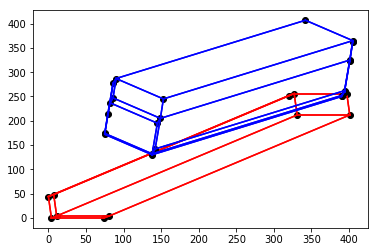

In [13]:
h[0].plot_dual_sub(color='red',name='b')

g[0].plot_dual_sub(color='blue',name='b')

# Полигоны Ньютона и subdivision для каждого из полиномов разницы по второй координате

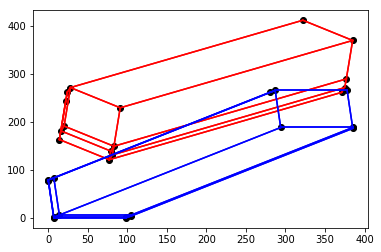

In [14]:
h[1].plot_dual_sub(color='red',name='b')

g[1].plot_dual_sub(color='blue',name='b')

# Минимизируем полиномы

In [15]:
h0_min = h[0].minimize()
h1_min = h[1].minimize()
g0_min = g[0].minimize()
g1_min = g[1].minimize()

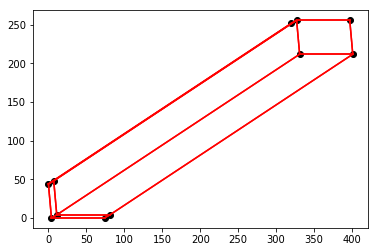

In [16]:
h0_min.plot_dual_sub(color='red',name='b')

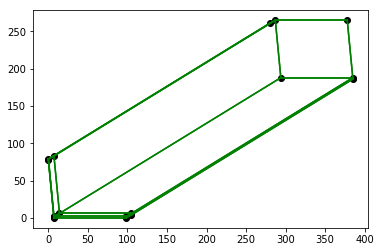

In [17]:
g1_min.plot_dual_sub(color='green',name='b')

Видно, что противоположные полиномы очень похожи

# Составляем полином из статьи

In [18]:
h0g1_min = (h0_min*g1_min).minimize()

In [19]:
h1g0_min = (h1_min*g0_min).minimize()

In [20]:
R = h0g1_min + h1g0_min

In [21]:
R_min = R.minimize()

# Полигоны Ньютона и subdivision для нового полинома и двух его слагаемых

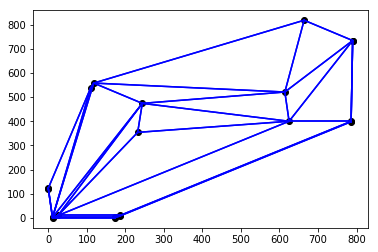

In [22]:
R_min.plot_dual_sub(color='blue',name='b')

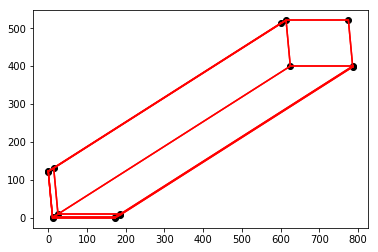

In [23]:
h0g1_min.plot_dual_sub(color='red',name='b')

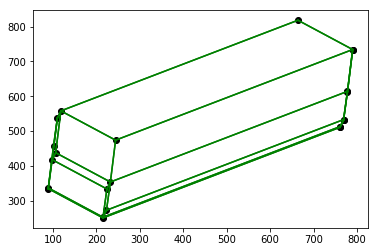

In [24]:
h1g0_min.plot_dual_sub(color='green',name='b')

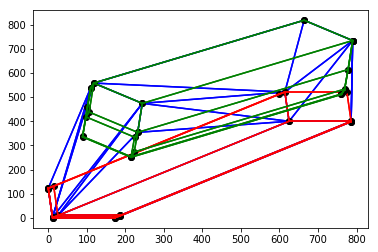

In [25]:
R_min.plot_dual_sub(color='blue',name='b')
h0g1_min.plot_dual_sub(color='red',name='b')
h1g0_min.plot_dual_sub(color='green',name='b')

Полином, который получали ребята из kausta

In [26]:
import sys
sys.path.append('TG-DNN/Playground/')

from Libraries import *
from Geometry_Plottings import *
from Geometry_utilities import *
from trainings import *

In [27]:
new_model = Net(10,2,2,True).to('cpu')

In [28]:
new_model

Net(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (relu): ReLU()
)

In [29]:
new_model.fc1.weight.data.copy_(model.linears[0].weight)
new_model.fc2.weight.data.copy_(model.linears[1].weight)

new_model.fc1.bias.data.copy_(model.linears[0].bias)
new_model.fc2.bias.data.copy_(model.linears[1].bias)

tensor([ 1., -3.], grad_fn=<CopyBackwards>)

In [30]:
boundary_vertices1,decision_boundary1 = get_model_polytopes(new_model,True,True,False) #True for getting the boundary polytope

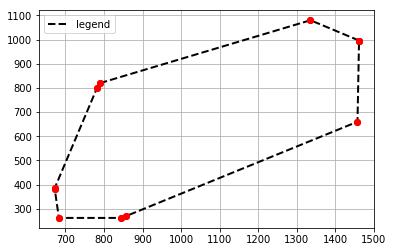

In [31]:
plot_polytope(boundary_vertices1,decision_boundary1)

# Рисуем реальную decision boundary исходной нейронки

In [32]:
def plot_decision_boundary(pred_func):
    xx,yy = np.meshgrid(np.arange(-5, 5, 0.001), np.arange(-5, 5, 0.001))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, alpha=0.1)   

In [33]:
def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model.forward(x)
    return ans.argmax(1).float().detach().numpy()

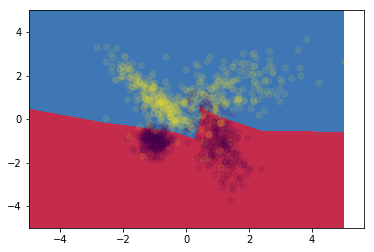

In [34]:
plot_decision_boundary(lambda x : predict(x))

# Видно, что decision boundary перпендикулярны тем границам полигона Нюьтона, которые не покрыты полигонами слагаемых.

In [35]:
pred = model.forward(x_t).argmax(1)

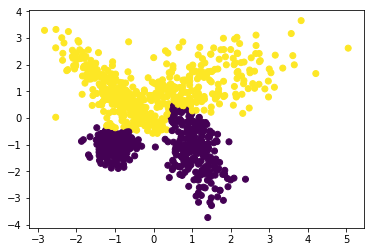

In [36]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=pred.detach().numpy().flatten())   